# 1. Import Libraries and Load Files

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load business file
df_b = pd.read_csv('../datasets/business2.csv')

In [3]:
# Load review file
df_r = pd.read_parquet("../datasets/parquet_file/review_filtered.parquet")

In [4]:
# Load user file
df_u = pd.read_parquet("../datasets/parquet_file/user.parquet")

# 2. Define Variables for Reliability Score

### (1) Expert Ratio

In [5]:
# -------------------------
# 1. Get top 3 categories for each users
# -------------------------

# Prepare business–category table
business = df_b.copy()

# Split the category string into a list per business
business["categories"] = (
    business["categories"]
    .fillna("")
    .str.split(",")
)

# One row per (business_id, category)
business_exploded = business.explode("categories")

# Clean up category strings and drop empty ones
business_exploded["categories"] = (
    business_exploded["categories"]
    .astype(str)
    .str.strip()
)
business_exploded = business_exploded[business_exploded["categories"] != ""]

# Remove overly generic categories
remove_keywords = ["restaurants", "food"]
business_exploded = business_exploded[
    ~business_exploded["categories"].str.lower().isin(remove_keywords)
]


# Attach categories to each review
df_review_cat = df_r.merge(
    business_exploded[["business_id", "categories"]],
    on="business_id",
    how="left"
)

# Count reviews per (user, category)
user_cat = (
    df_review_cat
    .groupby(["user_id", "categories"])
    .size()
    .reset_index(name="review_count")
)


# Get top 3 categories per user (most frequently reviewed categories)
top3 = (
    user_cat
    .sort_values(["user_id", "review_count"], ascending=[True, False])
    .groupby("user_id")
    .head(3)
)

# Aggregate into a list: ['Burgers', 'Coffee & Tea', 'Fast Food'] etc.
user_expert_cats = (
    top3.groupby("user_id")["categories"]
        .apply(list)
        .reset_index()
        .rename(columns={"categories": "top3_categories"})
)

# Merge back to df_u
df_u = df_u.merge(user_expert_cats, on="user_id", how="left")
df_u.head()


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,top3_categories
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,55,56,18,232,844,467,467,239,180,"[Sandwiches, American (Traditional), Bars]"
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,184,157,251,1847,7054,3131,3131,1521,1946,"[American (Traditional), Coffee & Tea, Seafood]"
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,10,17,3,66,96,119,119,35,18,"[American (New), Bakeries, Breakfast & Brunch]"
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,1,6,2,12,16,26,26,10,9,"[Cajun/Creole, Southern, American (Traditional)]"
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,0,0,0,1,1,0,0,0,0,"[American (Traditional), Bars, Nightlife]"


In [6]:
# ------------------------------------
# 2. Determine if the review is written by an expert user
# ------------------------------------

# Merge user info (top3_categories) into df_r
df_r = df_r.merge(
    df_u[["user_id", "top3_categories"]],
    on="user_id",
    how="left"
)

# Merge business category list into df_r
df_b["category_list"] = (
    df_b["categories"]
    .fillna("")
    .str.split(",")
    .apply(lambda lst: [c.strip() for c in lst if c.strip() != ""])
)

df_r = df_r.merge(
    df_b[["business_id", "category_list"]],
    on="business_id",
    how="left"
)

# Create is_expert_review column
def is_expert(row):
    user_cats = row["top3_categories"]
    biz_cats = row["category_list"]
    
    # If either is missing, treat as non-expert review
    if not isinstance(user_cats, list) or not isinstance(biz_cats, list):
        return False
    
    # Return True if any overlap exists
    return bool(set(user_cats) & set(biz_cats))


df_r["is_expert_review"] = df_r.apply(is_expert, axis=1)
df_r.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,top3_categories,category_list,is_expert_review
0,UYYEUH8qldJg4C4XqVX3Gg,gdcRlubKDmslUYFPHUp1Cg,--8IbOsAAxjKRoYsBFL-PA,2.0,6,0,0,Eh.. not that great don't waste your money on ...,2015-06-16 02:10:33,"[Cajun/Creole, American (New), Chinese]","[Food, Restaurants, Italian]",False
1,QzHuw7wadQIdzlc5HlLqvw,0OPQST9dAnfP5vRU0zw72g,--8IbOsAAxjKRoYsBFL-PA,1.0,0,0,0,"4706 Paris Ave, New Orleans, LA 70122 has the ...",2015-08-20 00:18:26,"[Chicken Wings, Italian]","[Food, Restaurants, Italian]",True
2,NKHDRXBZRxziLAVQZJusMg,CNeaJDD_ZihiafOvSGSpPw,--8IbOsAAxjKRoYsBFL-PA,5.0,0,1,1,Welcome to the neighborhood! Super sweet staff...,2015-09-01 23:32:20,"[Italian, Seafood, American (New)]","[Food, Restaurants, Italian]",True
3,4m0MjgAiz2783SBRmM9Hkg,KyjXy2dBGDPUP6aGqfXB6g,--8IbOsAAxjKRoYsBFL-PA,1.0,1,0,0,"Over the past few months, this place has becom...",2015-10-11 03:39:47,"[Cajun/Creole, Italian, Thai]","[Food, Restaurants, Italian]",True
4,RHkxe8-gdlGsh3eITN7ZDQ,Er_1k4cl0VwKz9tfIn-FBw,--8IbOsAAxjKRoYsBFL-PA,4.0,1,0,1,I always forget this place is in Gentilly. It'...,2015-10-13 03:29:21,"[Seafood, Nightlife, Bars]","[Food, Restaurants, Italian]",False


In [7]:
# ------------------------------------
# 3. Calculate final expert_review_ratio
# ------------------------------------
expert_stats = (
    df_r.groupby("business_id")
        .agg(
            total_reviews=("is_expert_review", "size"),
            expert_reviews=("is_expert_review", "sum"),
            review_count=("stars", "size")
        )
        .reset_index()
)

# Compute expert review ratio (0~1)
expert_stats["expert_review_ratio"] = (
    expert_stats["expert_reviews"] / expert_stats["total_reviews"]
)

In [8]:
# ------------------------------------
# 4. Normalize expert_ratio
# ------------------------------------

# Log-transform the expert ratio for smoothing
expert_stats['expert_ratio_adjusted'] = np.log1p(expert_stats['expert_review_ratio'] * 9) / np.log(10)

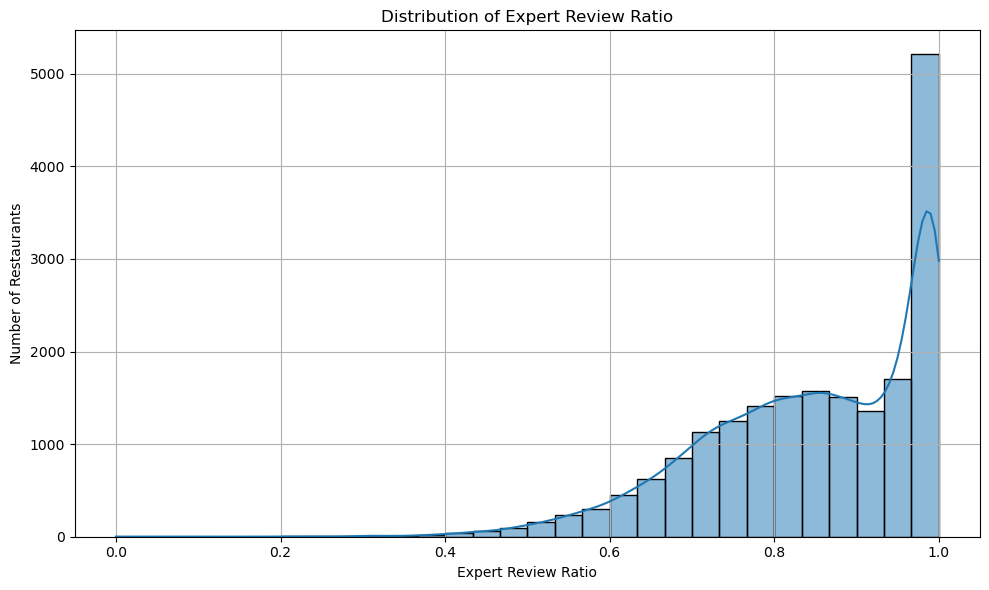

In [9]:
# -------------------------
# 5. Check the distribution of Expert Review Ratio
# -------------------------
plt.figure(figsize=(10, 6))
sns.histplot(expert_stats['expert_ratio_adjusted'], bins=30, kde=True)

plt.title('Distribution of Expert Review Ratio')
plt.xlabel('Expert Review Ratio')
plt.ylabel('Number of Restaurants')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# ------------------------------------
# 6. Merge into the main business dataframe
# ------------------------------------
df_b = df_b.merge(
    expert_stats[["business_id", "expert_ratio_adjusted"]],
    on="business_id",
    how="left"
)

### (2) Elite Review Ratio

In [11]:
# -------------------------
# 1. Determine wether the review was written by elite user
# -------------------------

# Merge review and user tables on user_id
df_review_merged = df_r.merge(df_u[['user_id', 'elite']], on='user_id', how='left')

# Make sure the 'date' column is in datetime format
df_review_merged['date'] = pd.to_datetime(df_review_merged['date'], errors='coerce')

# Function: check if reviewer was elite at the time of review
def was_elite_at_review(review_date, elite_years):
    if pd.isna(elite_years) or elite_years in ["None", ""]:  # No elite history
        return 0
    if pd.isna(review_date):
        return 0

    try:
        # Extract the year of the review (e.g., 2018)
        review_year = review_date.year

        # Parse elite years safely (e.g., '2009,2010,2011,...')
        years = []
        for y in str(elite_years).split(','):
            y = y.strip()
            if y.isdigit():
                years.append(int(y))

        # Return 1 if the review year is in the elite year list
        return 1 if review_year in years else 0
    except Exception as e:
        print(f"⚠️ Error parsing elite_years for a row: {e}")
        return 0

# Apply the function row by row
df_review_merged['review_by_elite'] = df_review_merged.apply(
    lambda x: was_elite_at_review(x['date'], x['elite']),
    axis=1
)

# Merge 'review_by_elite' from df_review_merged into df_r
df_r = df_r.merge(
    df_review_merged[['review_id', 'review_by_elite']],
    on='review_id',
    how='left'
)


In [12]:
# -------------------------
# 2. Calculate elite_review_count
# -------------------------

# Count total reviews per business
review_cnt = (
    df_r.groupby("business_id")["review_id"]
        .count()
        .reset_index(name="review_count")
)

# Count how many reviews were written by elite users
elite_cnt = (
    df_r[df_r["review_by_elite"] == 1]
        .groupby("business_id")["review_id"]
        .count()
        .reset_index(name="elite_review_count")
)

# Merge both counts and replace missing elite counts with zero
elite_review = (
    review_cnt
    .merge(elite_cnt, on="business_id", how="left")
    .fillna({"elite_review_count": 0})
)

# Convert to integer
elite_review["elite_review_count"] = elite_review["elite_review_count"].astype(int)


In [13]:
# -------------------------
# 3. Calculate elite_review_ratio
# -------------------------
elite_review['elite_review_ratio'] = elite_review['elite_review_count'] / elite_review['review_count']


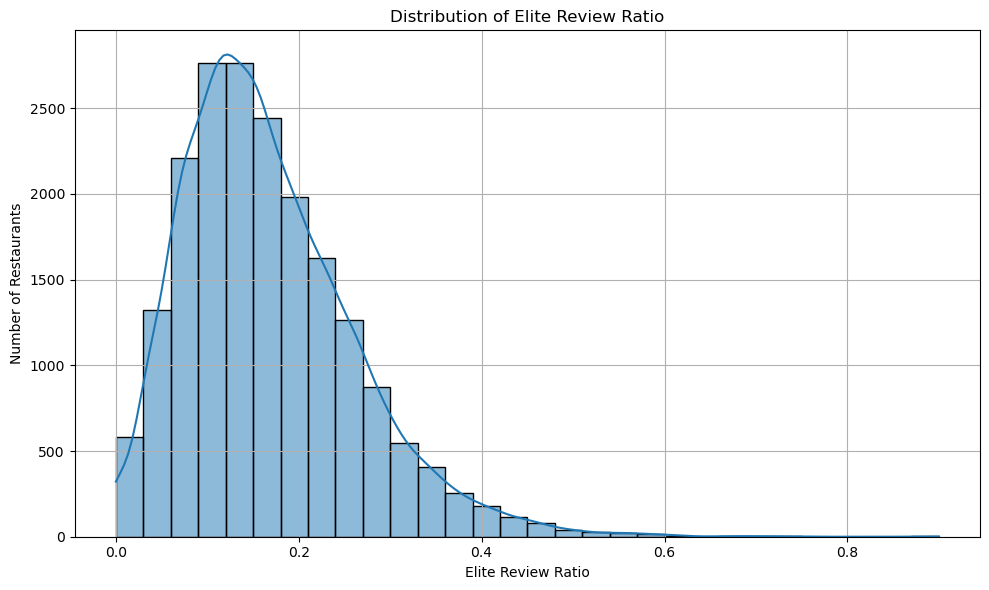

In [14]:
# -------------------------
# 4. Check the distribution of Elite Review Ratio
# -------------------------
plt.figure(figsize=(10, 6))
sns.histplot(elite_review['elite_review_ratio'], bins=30, kde=True)

plt.title('Distribution of Elite Review Ratio')
plt.xlabel('Elite Review Ratio')
plt.ylabel('Number of Restaurants')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# ------------------------------------
# 5. Merge into the main business dataframe
# ------------------------------------
df_b = df_b.merge(
    elite_review[['business_id', 'elite_review_ratio']],
    on='business_id',
    how='left'
)

# 3. Calculate Final Reliability Score

In [16]:
# Calculate final loyalty score
df_b['reliability_score'] = (
    40 * df_b['expert_ratio_adjusted'] + 
    60 * df_b['elite_review_ratio']
)

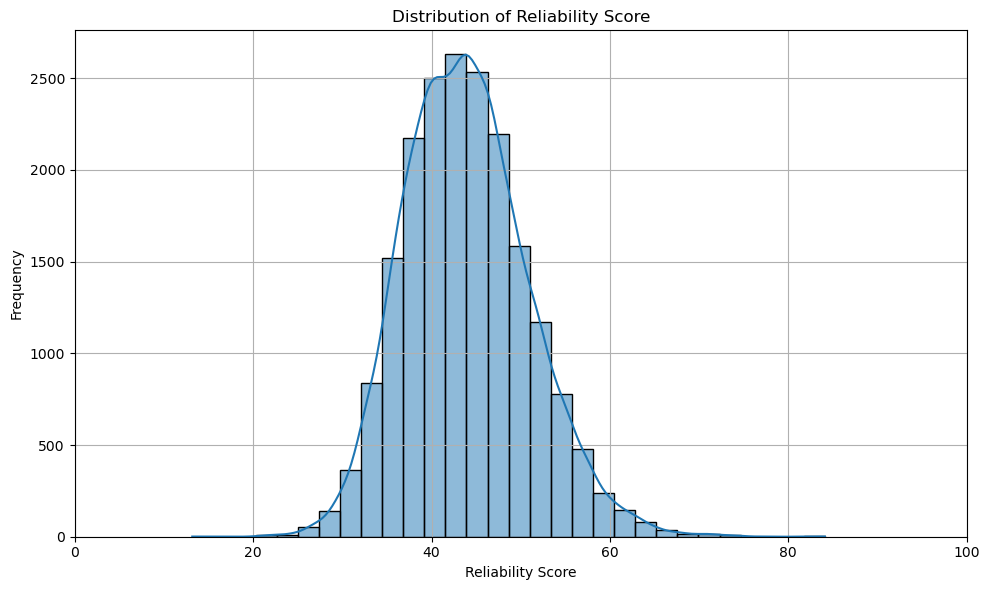

In [17]:
# Check distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_b['reliability_score'], bins=30, kde=True)

plt.title('Distribution of Reliability Score')
plt.xlabel('Reliability Score')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Save the final dataset as a CSV file
df_b.drop(columns=['category_list', 'expert_ratio_adjusted', 'elite_review_ratio'], inplace=True)
df_b.to_csv('../datasets/business3.csv', index=False)